In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras import mixed_precision
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
mixed_precision.set_global_policy('mixed_float16')

###Data collection 📊🔎

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [ ]:
# Set Kaggle API key path
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

# Download dataset
!kaggle datasets download ismailpromus/skin-diseases-image-dataset

# Unzip dataset
dataset_dir = 'skin-diseases-image-dataset'
with zipfile.ZipFile('skin-diseases-image-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)

Dataset URL: https://www.kaggle.com/datasets/ismailpromus/skin-diseases-image-dataset
License(s): copyright-authors
100% 5.19G/5.19G [04:14<00:00, 21.6MB/s]
100% 5.19G/5.19G [04:14<00:00, 21.9MB/s]


In [ ]:
# Define paths and classes
class_labels = [
    'Psoriasis pictures Lichen Planus and related diseases',
    'Seborrheic Keratoses and other Benign Tumors',
    'Warts Molluscum and other Viral Infections'
]

folder_paths = [
    os.path.join(dataset_dir, 'IMG_CLASSES', '7. Psoriasis pictures Lichen Planus and related diseases - 2k'),
    os.path.join(dataset_dir, 'IMG_CLASSES', '8. Seborrheic Keratoses and other Benign Tumors - 1.8k'),
    os.path.join(dataset_dir, 'IMG_CLASSES', '10. Warts Molluscum and other Viral Infections - 2103')
]

In [ ]:
# Load dataframe
file_paths = []
labels = []
for class_idx, folder in enumerate(folder_paths):
    for img_file in os.listdir(folder):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_paths.append(os.path.join(folder, img_file))
            labels.append(class_labels[class_idx])

skin_df = pd.DataFrame({'filepaths': file_paths, 'labels': labels})

In [ ]:
print(skin_df.head())
print(skin_df["labels"].value_counts())
print(f"Total images: {len(file_paths)}, Classes: {len(set(labels))}")

                                           filepaths  \
0  skin-diseases-image-dataset/IMG_CLASSES/7. Pso...   
1  skin-diseases-image-dataset/IMG_CLASSES/7. Pso...   
2  skin-diseases-image-dataset/IMG_CLASSES/7. Pso...   
3  skin-diseases-image-dataset/IMG_CLASSES/7. Pso...   
4  skin-diseases-image-dataset/IMG_CLASSES/7. Pso...   

                                              labels  
0  Psoriasis pictures Lichen Planus and related d...  
1  Psoriasis pictures Lichen Planus and related d...  
2  Psoriasis pictures Lichen Planus and related d...  
3  Psoriasis pictures Lichen Planus and related d...  
4  Psoriasis pictures Lichen Planus and related d...  
labels
Warts Molluscum and other Viral Infections               2103
Psoriasis pictures Lichen Planus and related diseases    2055
Seborrheic Keratoses and other Benign Tumors             1847
Name: count, dtype: int64
Total images: 6005, Classes: 3


###Split data

In [ ]:
# 5. Train-Validation-Test Split
train_df, temp_df = train_test_split(
    skin_df,
    test_size=0.3,
    stratify=skin_df['labels'],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['labels'],
    random_state=42
)

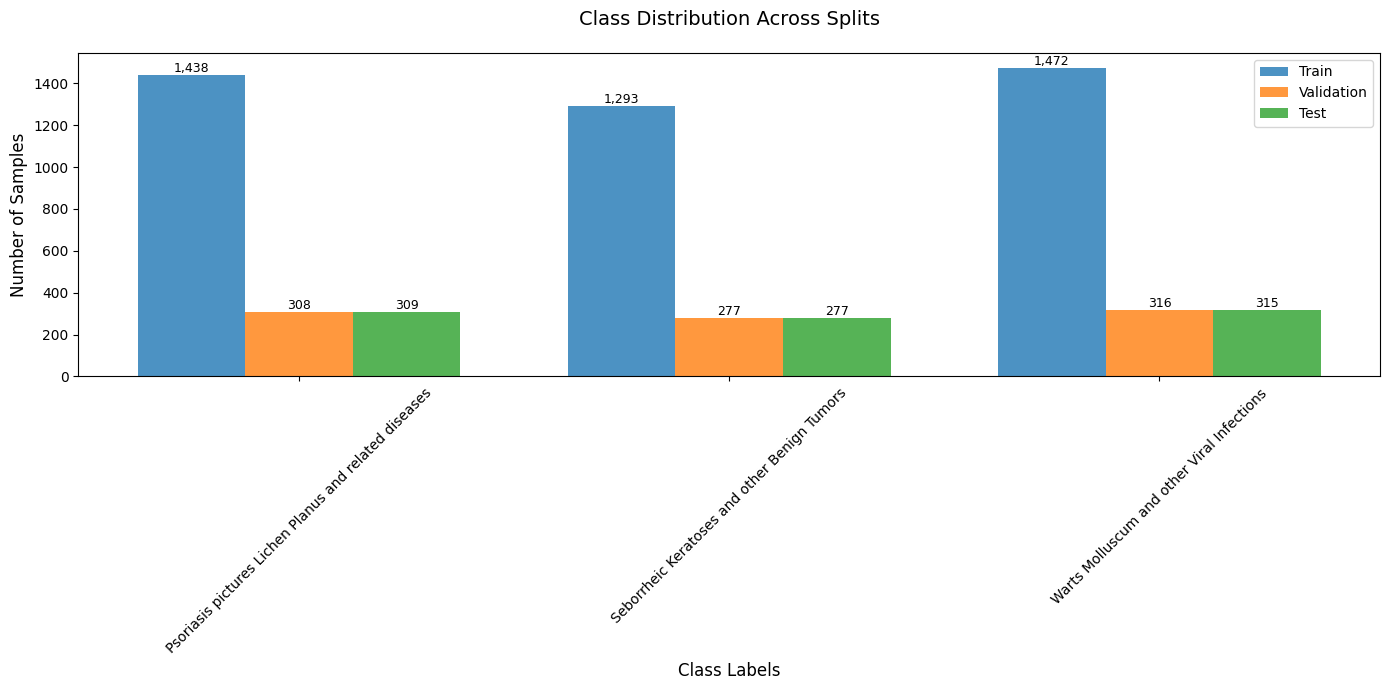

In [ ]:
# Create figure for visualization
plt.figure(figsize=(14, 7))

# Get class counts for each split
train_counts = train_df['labels'].value_counts().sort_index()
val_counts = val_df['labels'].value_counts().sort_index()
test_counts = test_df['labels'].value_counts().sort_index()

# Create bar positions and width
bar_width = 0.25
index = range(len(train_counts))  # Class indices

# Plot bars for each split
train_bars = plt.bar(index, train_counts, bar_width,
                    label='Train', color='#1f77b4', alpha=0.8)
val_bars = plt.bar([i + bar_width for i in index], val_counts, bar_width,
                  label='Validation', color='#ff7f0e', alpha=0.8)
test_bars = plt.bar([i + 2*bar_width for i in index], test_counts, bar_width,
                   label='Test', color='#2ca02c', alpha=0.8)

# Customize plot
plt.title('Class Distribution Across Splits', fontsize=14, pad=20)
plt.xlabel('Class Labels', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks([i + bar_width for i in index], train_counts.index, rotation=45)
plt.legend()

# Add count labels on top of bars
for bars in [train_bars, val_bars, test_bars]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

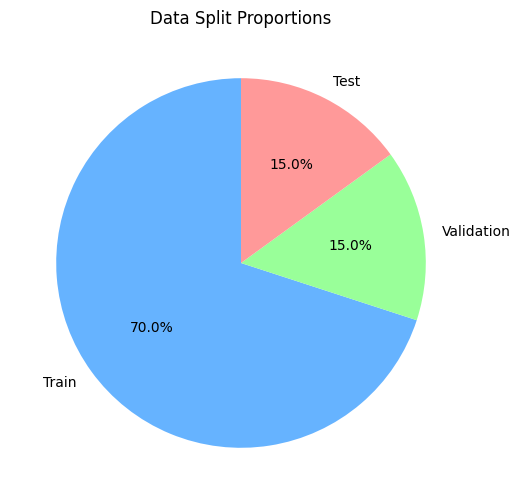

In [ ]:
# Calculate proportions
total = len(skin_df)
train = len(train_df) / total
val = len(val_df) / total
test = len(test_df) / total

# Basic pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    [train, val, test],
    labels=['Train', 'Validation', 'Test'],
    colors=['#66b3ff', '#99ff99', '#ff9999'],
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Data Split Proportions')
plt.show()

###Data preparation

In [ ]:
# 6. Dataset Creation with tf.data
IMG_SIZE = (300, 300)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def load_and_preprocess_image(path, label):
    # 1. Read image from path
    image = tf.io.read_file(path)

    # 2. Decode and resize
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)

    # 3. Apply EfficientNet preprocessing
    image = tf.keras.applications.efficientnet.preprocess_input(image)

    return image, label

def create_dataset(df, shuffle=False):
    # Create dataset from paths and labels
    paths = df['filepaths'].values
    labels = df['labels'].astype('category').cat.codes.values

    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))

    # Load and preprocess images
    dataset = dataset.map(
        lambda path, label: load_and_preprocess_image(path, label),
        num_parallel_calls=AUTOTUNE
    )

    # Data augmentation
    if shuffle:
        dataset = dataset.map(
            lambda image, label: (tf.image.random_flip_left_right(image), label),
            num_parallel_calls=AUTOTUNE
        )
        dataset = dataset.map(
            lambda image, label: (tf.image.random_brightness(image, 0.2), label),
            num_parallel_calls=AUTOTUNE
        )

    # Performance optimizations
    dataset = dataset.cache()
    if shuffle:
        dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset.prefetch(AUTOTUNE)

In [ ]:
# Create datasets
train_ds = create_dataset(train_df, shuffle=True)
val_ds = create_dataset(val_df)
test_ds = create_dataset(test_df)

#####Visualize images

In [ ]:
def visualize_images(dataset, class_names, num_images=9):
    # Take one batch from the dataset
    for images, labels in dataset.take(1):
        # Create a grid of images
        plt.figure(figsize=(15, 15))

        for i in range(num_images):
            # Convert image tensor to numpy array and denormalize
            image = images[i].numpy()
            image = (image - image.min()) / (image.max() - image.min())  # Scale to [0, 1]

            # Plot
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(image)
            plt.title(class_names[labels[i]])
            plt.axis("off")

        plt.tight_layout()
        plt.show()

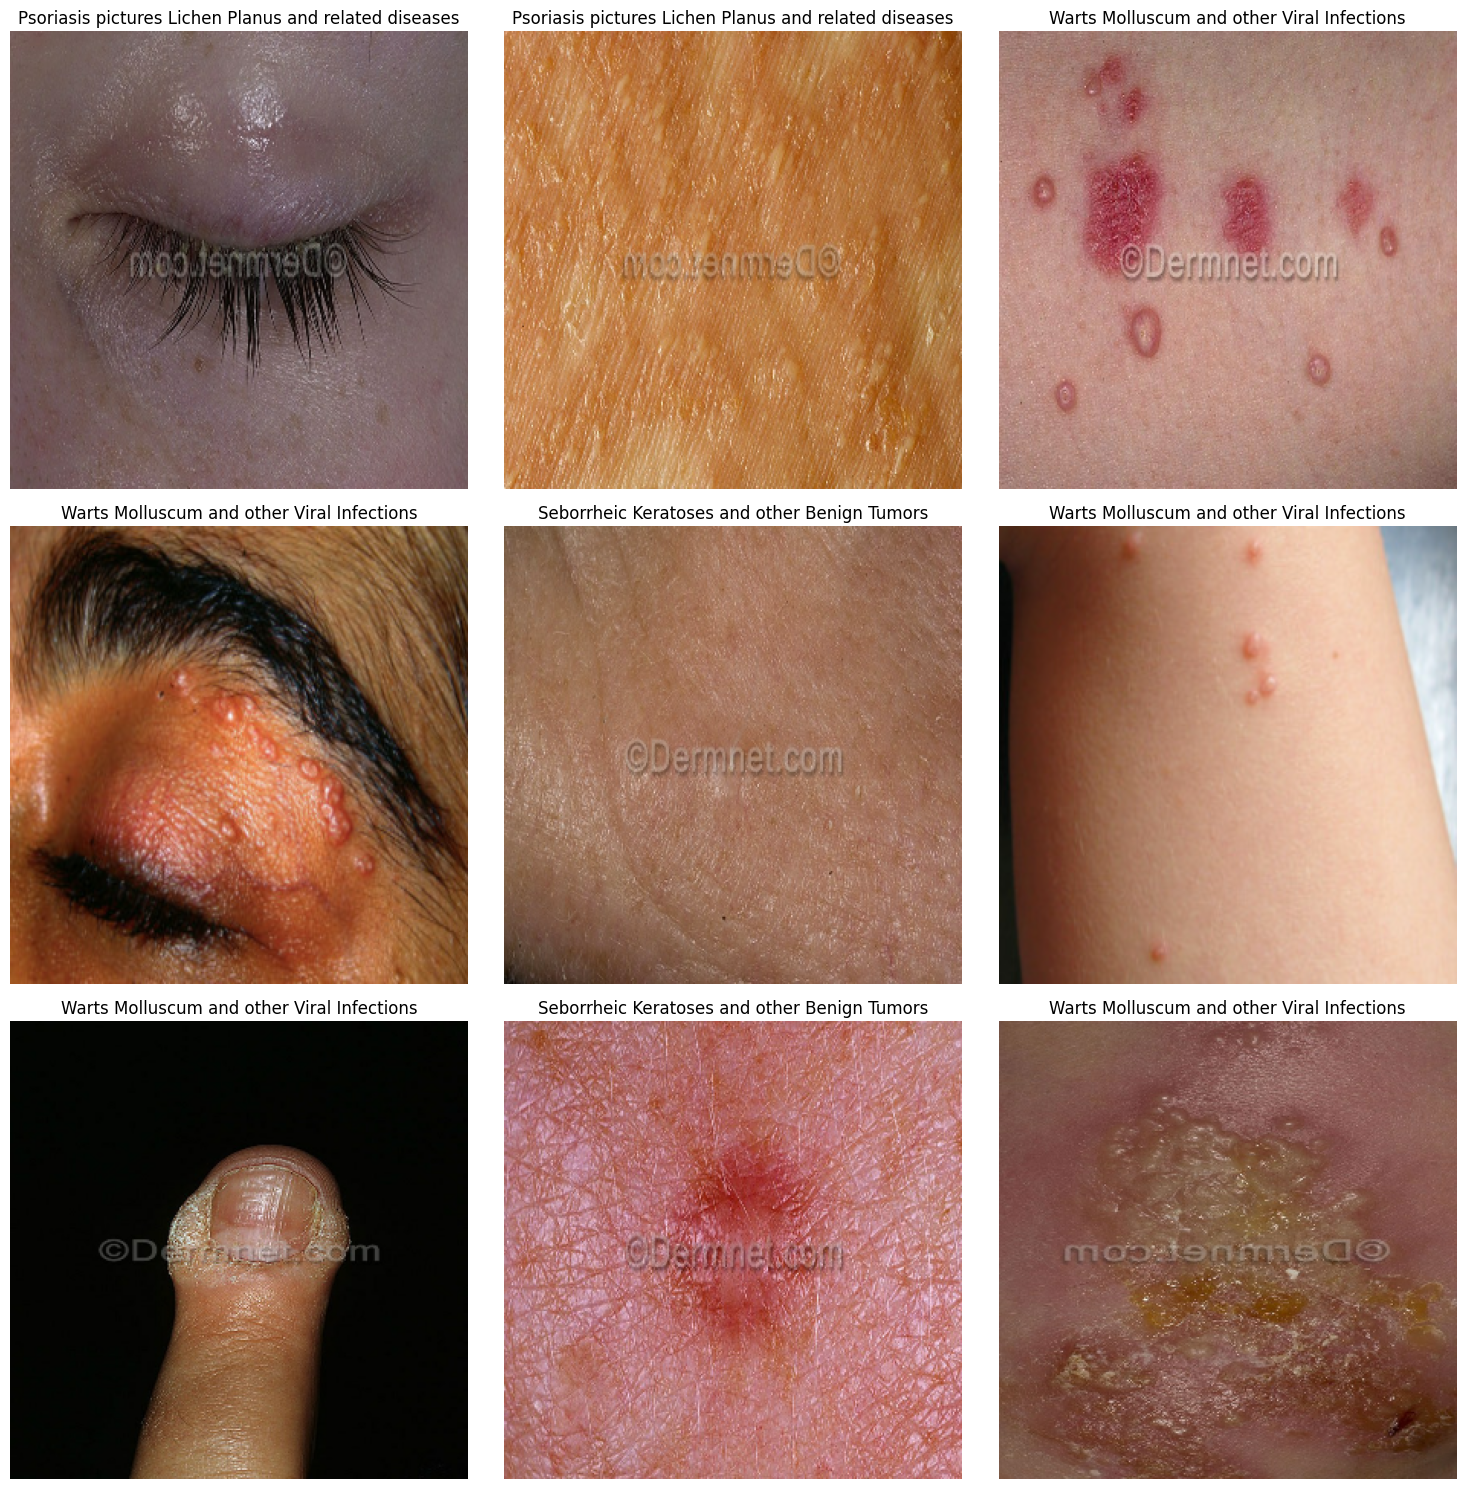

In [ ]:
visualize_images(train_ds, class_labels)

###Bulid the model 🤖

In [ ]:
# 7. Model Building

def build_model():
    # Base model
    base_model = EfficientNetB3(
        include_top=False,
        weights='imagenet',
        input_shape=(*IMG_SIZE, 3),
        pooling='avg'
    )

    # Freeze first 80% layers
    for layer in base_model.layers[:int(len(base_model.layers)*0.8)]:
        layer.trainable = False

    # Custom head
    inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))
    x = base_model(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu',
                    kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(class_labels),
                          activation='softmax',
                          dtype='float32')(x)

    model = models.Model(inputs, outputs)

    # Compile
    model.compile(
        optimizer=Adamax(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = build_model()

In [ ]:
# 8. Training Configuration

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_df['labels'].astype('category').cat.codes),
    y=train_df['labels'].astype('category').cat.codes
)
class_weights = dict(enumerate(class_weights))

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

In [ ]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


###Training 🧠

In [ ]:
# 9. Training Execution

print("\nStarting training...")
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=callbacks
)


Starting training...
Epoch 1/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 99s 379ms/step - accuracy: 0.5737 - loss: 1.3998 - val_accuracy: 0.7114 - val_loss: 0.7371 - learning_rate: 0.0010
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.7745 - loss: 0.6399 - val_accuracy: 0.7769 - val_loss: 0.6456 - learning_rate: 0.0010
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8438 - loss: 0.4347 - val_accuracy: 0.7891 - val_loss: 0.6500 - learning_rate: 0.0010
Epoch 4/10
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9031 - loss: 0.3049
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9030 - loss: 0.3049 - val_accuracy: 0.8080 - val_loss: 0.6617 - learning_rate: 0.0010
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.9172 - loss: 0.2621 - val_accuracy: 0.8246 - val_loss: 0.6224 - learning_rate: 5.0000e-04
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - 

In [ ]:
# 10. Evaluation

print("\nEvaluating on test set...")
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc:.2%}")

# Generate predictions
y_pred = model.predict(test_ds).argmax(axis=1)
y_true = test_df['labels'].astype('category').cat.codes.values

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


Evaluating on test set...
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8322 - loss: 0.5100

Test Accuracy: 83.80%
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 314ms/step

Classification Report:
                                                       precision    recall  f1-score   support

Psoriasis pictures Lichen Planus and related diseases       0.85      0.85      0.85       309
         Seborrheic Keratoses and other Benign Tumors       0.84      0.80      0.82       277
           Warts Molluscum and other Viral Infections       0.83      0.86      0.85       315

                                             accuracy                           0.84       901
                                            macro avg       0.84      0.84      0.84       901
                                         weighted avg       0.84      0.84      0.84       901



###Result 🎯

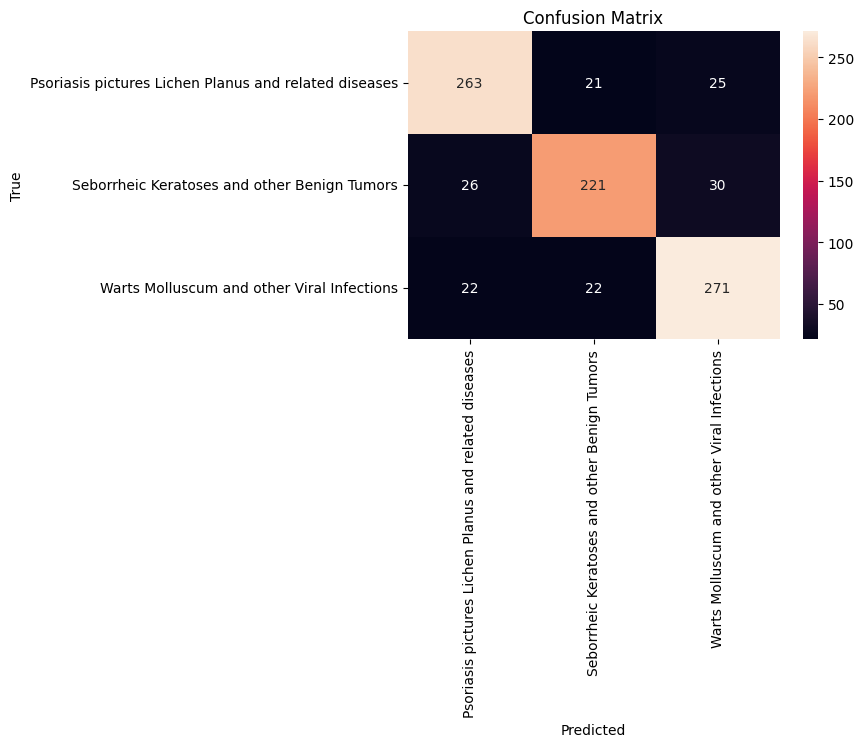

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_true, y_pred),
            annot=True, fmt='d',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

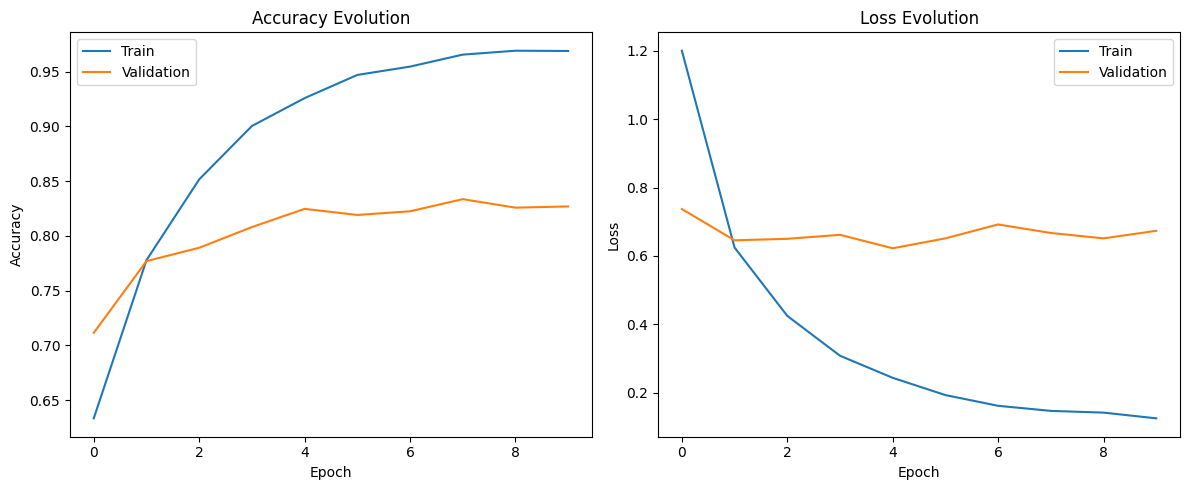

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy Evolution')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss Evolution')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def predict_and_display(image_path, class_labels, img_size=(300, 300)):
# Load the original image for display (without model processing)
    original_img = tf.io.read_file(image_path)
    original_img = tf.image.decode_jpeg(original_img, channels=3)
    original_img = tf.image.resize(original_img, img_size)  # للعرض فقط

# Load the image for preprocessing (for prediction)
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    img = tf.expand_dims(img, axis=0)

    pred = model.predict(img)
    class_idx = np.argmax(pred)
    confidence = np.max(pred)

# Display the original image with the classification
    plt.figure(figsize=(8, 8))
    plt.imshow(original_img / 255.0)  # Convert to [0,1] range for display
    plt.title(f"Class: {class_labels[class_idx]}\nConfidence: {confidence:.2%}", fontsize=14, fontweight='bold', pad=20)
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


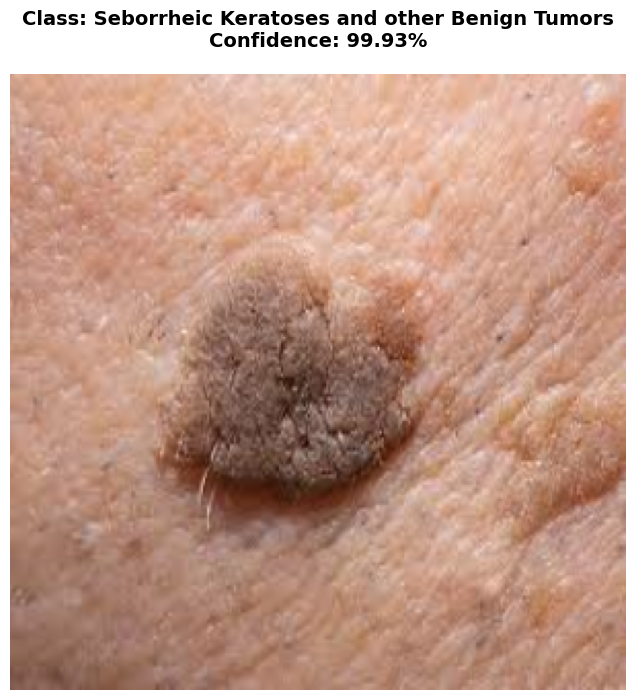

In [ ]:
predict_and_display(
    image_path="Seborrheic Keratoses and other Benign Tumors.jpg",
    class_labels=class_labels
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


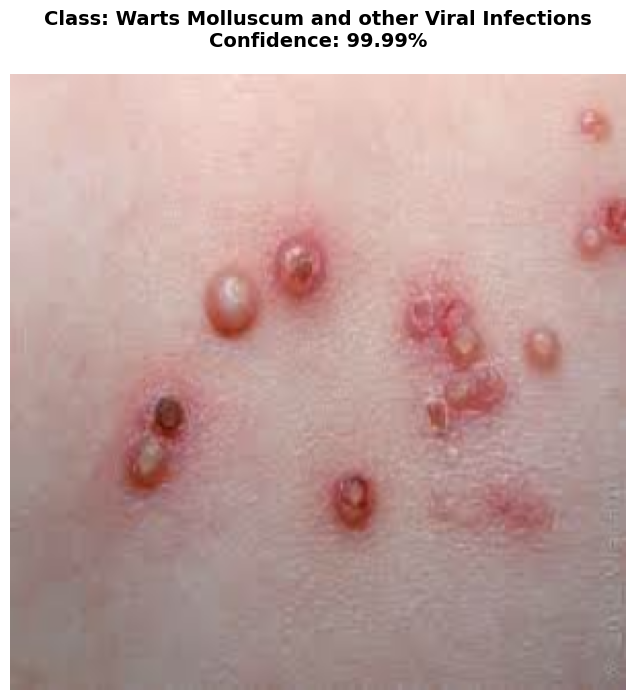

In [ ]:
predict_and_display(
    image_path="Warts Molluscum and other Viral Infections.jpg",
    class_labels=class_labels
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


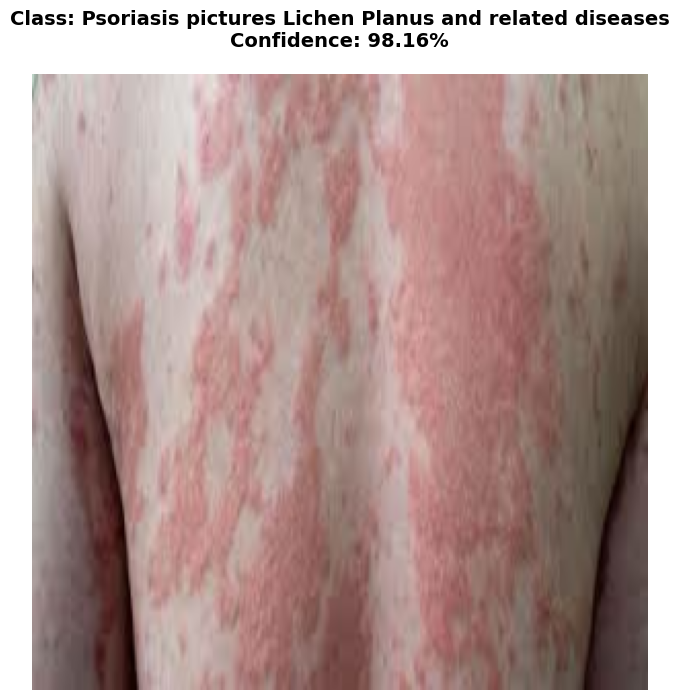

In [ ]:
predict_and_display(
    image_path="Psoriasis pictures Lichen Planus and related diseases.jpg",
    class_labels=class_labels
)
